# Market Basket Analysis

The Market Basket Analysis is an unsupervised model which identifies and measures relationships among products. It is used by companies to identify items that are frequently purchased together.

In [32]:
import pandas as pd

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [33]:
orders = pd.read_csv('tbl_orders.csv')  # 1.039.865 rows
products = pd.read_csv('tbl_products.csv')  # 88.538 rows

In the pre-processing we had carried out an exploration phase on both datasets, noting that the most purchased product category was number 3. In order of ranking we find category 3 (30.5%), followed by category 11 (12.9%) and then category 10 (10.9%).

## Pre-processing

For the purpose of the market basket, we have to perform a cleaning phase of the dataset, in particular we have to eliminate refunds (rows with direction equal to -1) and duplicates, as well as orders involving the purchase of only one product.

In [34]:
print(f"Total number of rows: {orders.shape[0]}")

Numero di righe totali: 1039865


In [35]:
# Remove all rows that have direction equal to -1
orders_pos_dir = orders[orders['direction'] != -1]

print(f"Number of rows without refund: {orders_pos_dir.shape[0]}")

Numero di righe senza refund: 977308


In [36]:
# Remove duplicates as we are interested in the relationships between different products
no_duplicates = orders_pos_dir.drop_duplicates()

print(f"Number of rows without duplicates: {len(no_duplicates)}")

Numero di righe senza duplicati: 886281


In [37]:
# Remove orders containing only one product as we are interested in the relationships between several different products
conteggio_prodotti = no_duplicates['order_id'].value_counts()
ordini_con_piu_prodotti = conteggio_prodotti[conteggio_prodotti > 1].index
df_filtrato = no_duplicates[no_duplicates['order_id'].isin(ordini_con_piu_prodotti)]

print(f"Number of rows with several products in a single order: {len(df_filtrato)}")

Numero di righe con più prodotti in un singolo ordine: 724311


Now we only select the variables 'order_id' and 'product_id' as we need to create an array containing binary values. On the rows we will enter all order numbers, and as variables on the columns we will enter the product id. Each cell will contain either value 0 or value 1 depending on whether or not that specific product was purchased in that order.

In [38]:
mb_df = df_filtrato[['order_id', 'product_id']]
mb_df.head()

,order_id,product_id
0,8fe4346b53d0c781b275a614175804de,35551922
1,8fe4346b53d0c781b275a614175804de,30344384
2,8fe4346b53d0c781b275a614175804de,33794292
3,8fe4346b53d0c781b275a614175804de,33795776
4,8fe4346b53d0c781b275a614175804de,36235381


## Pivoting

**Note**: direct pivoting of the table is too memory-intensive so we use the TransactionEncoder from mlxtend.preprocessing: there is no need for explicit pivoting. The TransactionEncoder function directly transforms the list of transaction lists into a binary transaction DataFrame, where each row represents an order and each column represents a product, indicating the presence or absence of the product in the order with binary values (0 or 1).

In [39]:
fake_pivot = pd.crosstab(mb_df['order_id'], mb_df['product_id'])
fake_pivot = fake_pivot.astype('int8')  # dal int64 a int8 per questioni di memoria

fake_pivot[fake_pivot > 0].head()

product_id,504553,30033521,30044455,30062452,30072014,30097186,30097291,30097340,30099454,30126292,...,82019008,82026198,82026199,82029521,82029522,82040488,82042962,82042965,82042968,82042974
order_id,,,,,,,,,,,,,,,,,,,,,
0000901a817e533f4a95d2839c5575a3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000f2817342879fac36a6b9f6a55990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001231326e40e177b91e3bbe2c85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00022115c5638382d758a0d7dd9ee0a1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000268e2f8e3612058d55568fa884b9e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
basket_input = fake_pivot
basket_input[basket_input > 0] = 1

basket_input.head()

product_id,504553,30033521,30044455,30062452,30072014,30097186,30097291,30097340,30099454,30126292,...,82019008,82026198,82026199,82029521,82029522,82040488,82042962,82042965,82042968,82042974
order_id,,,,,,,,,,,,,,,,,,,,,
0000901a817e533f4a95d2839c5575a3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f2817342879fac36a6b9f6a55990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001231326e40e177b91e3bbe2c85358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00022115c5638382d758a0d7dd9ee0a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000268e2f8e3612058d55568fa884b9e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Once the matrix has been created, we move on to the use of the priori algorithm. The a priori algorithm is an association search algorithm. It is used for the generation of frequent itemsets, by successive approximations, from itemsets with only one element.

## Apriori algorithm

We selected the following variables:

- **min_support=0.005**.
minimum support threshold required for a set of elements to be considered 'frequent'. The support of a set of elements is the frequency with which it appears in all transactions. In our case, the algorithm will only identify element sets that appear at least 0.5% of the time in transactions
- **use_columnames=True**
the column names of the dataset will be used to label the elements in the output instead of the numeric indices of the elements.
- **max_len=3**
Limits the maximum length of the element sets that the algorithm will attempt to find. In our case, the algorithm will only search for element sets with a maximum length of 3.
- **verbose=1**
controls the level of detail of the output during the execution of the algorithm. A higher value generates more information during execution.
- **low_memory=True**
this parameter instructs the algorithm to use low memory consumption strategies to perform the calculation of frequent itemsets, especially on large datasets.

In [41]:
frequent_itemsets = apriori(basket_input, min_support=0.005, use_colnames=True, max_len=3, verbose=1, low_memory=True )
rules = association_rules(frequent_itemsets, metric="lift")

rules.head()

/Users/giorgiaprina/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Processing 12 combinations | Sampling itemset size 3


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(31618321),(31618300),0.008946,0.012378,0.005279,0.590087,47.671508,0.005168,2.409348,0.987860
1,(31618300),(31618321),0.012378,0.008946,0.005279,0.426464,47.671508,0.005168,1.727973,0.991294
2,(31618300),(31618405),0.012378,0.011679,0.007068,0.571007,48.890863,0.006923,2.303817,0.991823
3,(31618405),(31618300),0.011679,0.012378,0.007068,0.605181,48.890863,0.006923,2.501454,0.991122
4,(31618300),(34129942),0.012378,0.011737,0.006531,0.527602,44.953583,0.006385,2.092015,0.990009


How to read the results: 
1. **Support**: It signifies the popularity of the item, if an item is less frequently bought then it will be ignored in the association.

Support = frq(X,Y)/N

2. **Confidence**: It tells the likelihood of purchasing Y when X is bought. It is a conditional probability but it fails to check the popularity(frequency) of Y to overcome that we got lift.

Confidence = frq(X,Y)/frq(X)

3. **Lift**: It combines both confidence and support. A lift greater than 1 suggests that the presence of the antecedent increases the chances that the consequent will occur in a given transaction. Lift below 1 indicates that purchasing the antecedent reduces the chances of purchasing the consequent in the same transaction.

Lift(X->Y) = Conf(X->Y)/Supp(Y)

To get the most frequent item combinations in the entire dataset, let’s sort the dataset by support, confidence (min_conf = 0.5), and lift:

In [42]:
# filter results by confidence >= 0.5
rules = rules[rules['confidence'] >= 0.5]

top_rules = rules.sort_values(["support", "confidence","lift"], axis = 0, ascending = False)
top_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
24,(32079082),(32079103),0.013677,0.014397,0.009843,0.719680,49.988530,0.009646,3.515988,0.993585
25,(32079103),(32079082),0.014397,0.013677,0.009843,0.683696,49.988530,0.009646,3.118272,0.994310
21,(32078935),(32079103),0.013072,0.014397,0.008555,0.654429,45.456285,0.008366,2.852103,0.990955
20,(32079103),(32078935),0.014397,0.013072,0.008555,0.594203,45.456285,0.008366,2.432073,0.992287
19,(32078935),(32079082),0.013072,0.013677,0.007590,0.580607,42.451152,0.007411,2.351784,0.989377
18,(32079082),(32078935),0.013677,0.013072,0.007590,0.554920,42.451152,0.007411,2.217417,0.989984
8,(31618405),(34129942),0.011679,0.011737,0.007266,0.622153,53.009626,0.007129,2.615510,0.992730
9,(34129942),(31618405),0.011737,0.011679,0.007266,0.619111,53.009626,0.007129,2.594775,0.992787
14,(32078795),(32079103),0.010005,0.014397,0.007136,0.713243,49.541443,0.006992,3.437067,0.989717
28,(32842551),(32079103),0.010876,0.014397,0.007094,0.652278,45.306864,0.006938,2.834459,0.988681


Ordering only by confidence, i.e. by the probability of buying Y given that I buy X, would show us only a small part of the information contained in this data. Sorting instead by support, confidence and lift would give greater importance to the products that are most often purchased and their complementaries. Two products could in fact be purchased 99% of the time together but have very little impact in terms of sales on the total sold.
So, in our case we note that the product pairs **32079082** and **32079103** are popular and the most frequently purchased together.

In [43]:
ant_1 = products.loc[products['product_id'] == 32079082, 'product_class'].values
cons_1 = products.loc[products['product_id'] == 32079103, 'product_class'].values

print(f"The antecedent and consequent in first position are part of product category number {ant_1} and {cons_1}.")

L'antecedente e il conseguente in prima posizione fanno parte della categoria di prodotto numero [3] e [3]


In [44]:
ant_2 = products.loc[products['product_id'] == 32079103, 'product_class'].values
cons_2 = products.loc[products['product_id'] == 32079082, 'product_class'].values

print(f"The antecedent and consequent in the second position are part of product category number {ant_2} and {cons_2}.")

L'antecedente e il conseguente in seconda posizione fanno parte della categoria di prodotto numero [3] e [3]


In [45]:
ant_3 = products.loc[products['product_id'] == 32078935, 'product_class'].values
cons_3 = products.loc[products['product_id'] == 32079103, 'product_class'].values

print(f"The antecedent and consequent in the third position are part of product category number {ant_3} and {cons_3}.")

L'antecedente e il conseguente in terza posizione fanno parte della categoria di prodotto numero [3] e [3]


It should be noted that the products in the top three positions are all part of category number 3, i.e. also the best-selling product category of all (as well as the highest yielding).

## VISUALIZATION - Relationship between variables

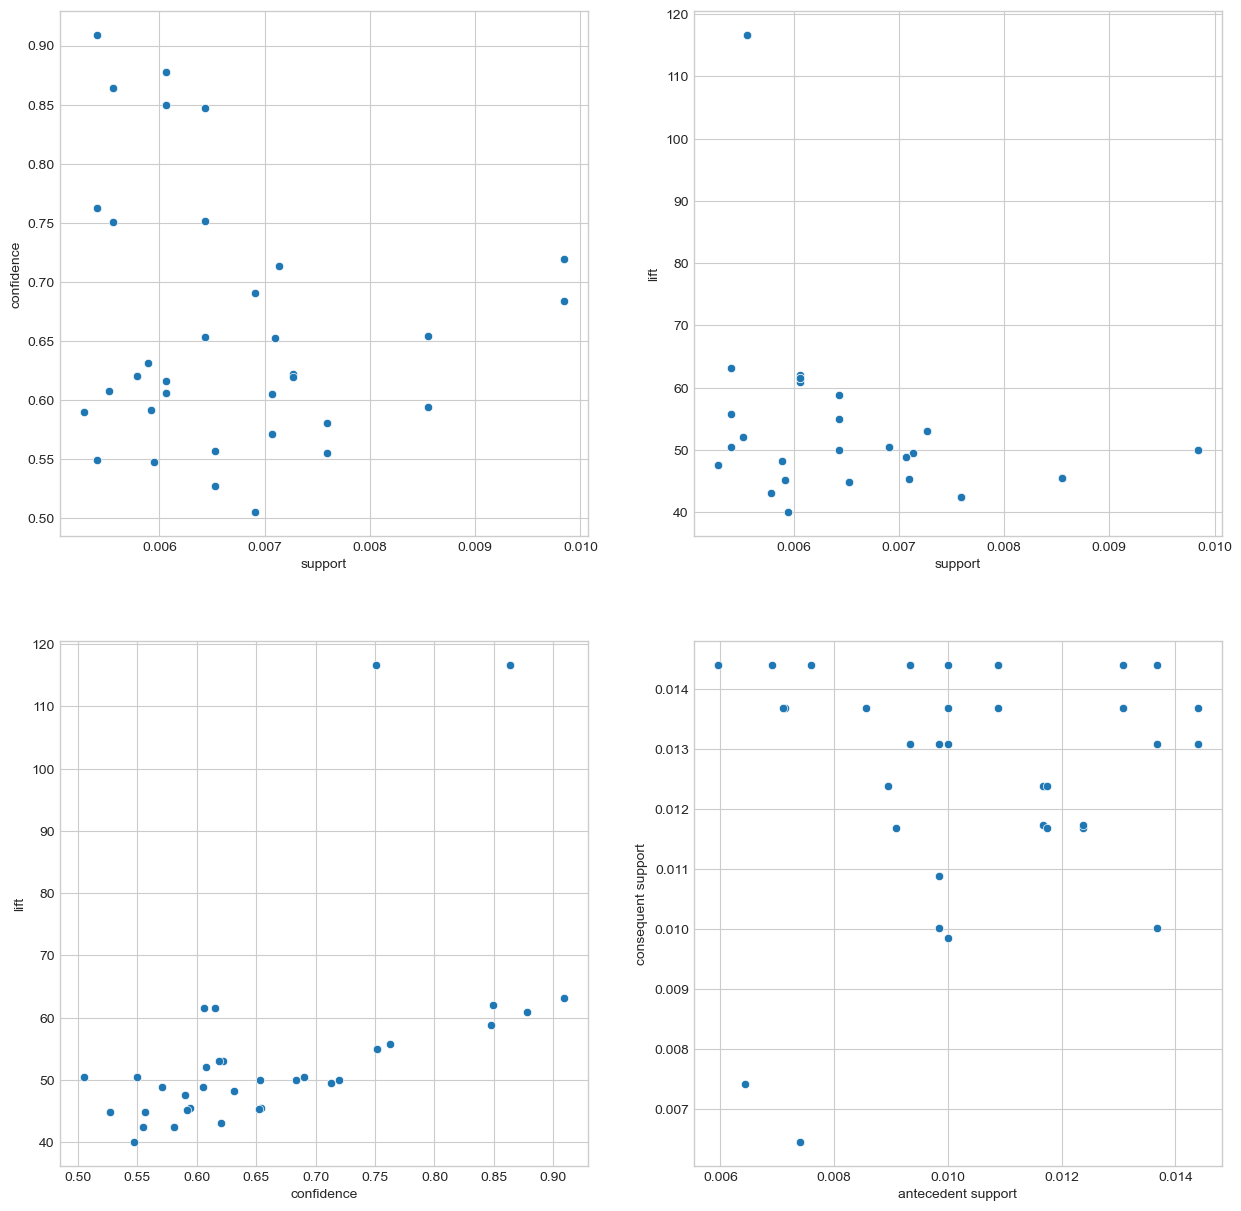

In [46]:
plt.figure(figsize=(15, 15))
plt.style.use('seaborn-v0_8-whitegrid')  # style
# Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence", data=top_rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift", data=top_rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift", data=top_rules)
plt.subplot(224)
sns.scatterplot(x="antecedent support", y="consequent support", data=top_rules)

plt.show()

We have represented through these scatterplots the relationship existing between the different pairs of variables. We note that there seems to be no relationship between confidence and support, in particular the values seem to be scattered and there is a wide variability between them. We can say the opposite in the graphs concerning the relationship between lift & support and lift & confidence. We actually expect a relationship to exist because we know that by definition the lift value sums up the results of support and confidence. In our case there is a positive relationship between lift and confidence, which means that as the confidence value increases (likelihood of purchasing Y when X is bought) the lift value also increases (the presence of the antecedent increases/decreases the chances that the consequent will occur in a given transaction).


Lack of relationship is also noticeable in the last graph in which we analyse the relationship between consequent support and antecedent support. Both indicate the frequency with which a particular set of elements (the antecedent or the consequent) occur within the dataset. In our case, it appears that they occur within the dataset homogeneously with respect to each other.

## VISUALIZATION - Network Diagram of Rules

Here we make network diagram of specified number of rules where we can see the antecedents and consequents connected to the rules.

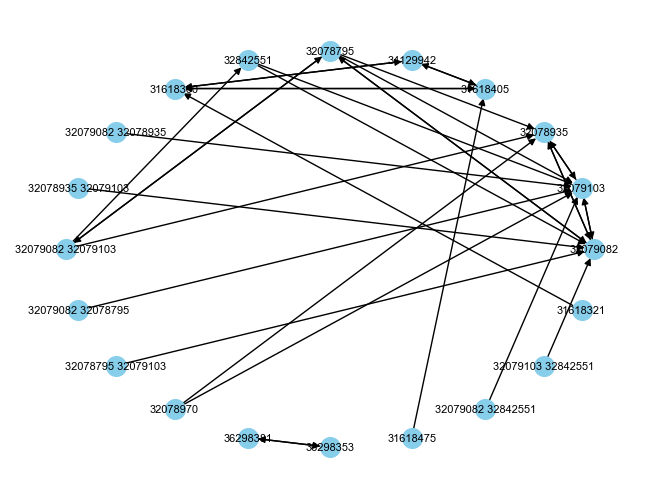

In [47]:
G = nx.DiGraph()

for index, rule in top_rules.iterrows():
    antecedent = ' '.join([str(item) for item in list(rule['antecedents'])])
    consequent = ' '.join([str(item) for item in list(rule['consequents'])])
    G.add_edge(antecedent, consequent, weight=rule['lift'])

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', arrows=True, font_size=8)
plt.show()

The Network Diagram shows us the presence of clusters or relationships between different sets. We note how two products in particular are related to each other (bottom centre). All the others appear to have a unique or bi-unique relationship with one or more of the products. In the image, we notice that there are nodes indicating single products or pairs of products from which an arrow with a single direction emerges. This indicates that that node is a generator node, i.e. an antecedent. Other nodes, on the other hand, are receivers of arrows, i.e. they are consequents. We also note that consequents are often consequents of more than one product at the same time. Finally, there are nodes that are both receptors and generators, i.e. nodes that represent products that in the dataframe created are in one row antecedents and in another consequents. 

## VISUALIZATION - Heatmap

We have discovered the association of items, we now analyse the strength of their relationship using a heatmap.

In [48]:
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = top_rules.pivot(index='antecedents', columns='consequents', values='lift')

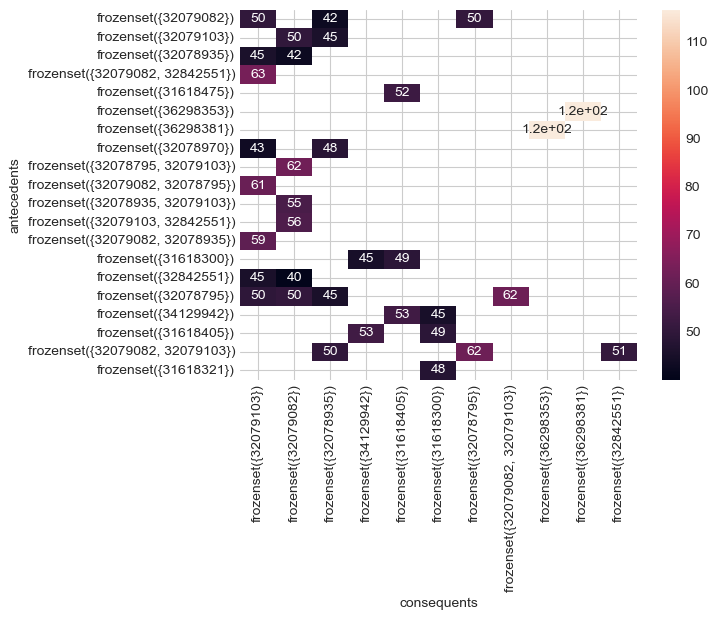

In [49]:
sns.heatmap(pivot, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [50]:
ant_h1 = products.loc[products['product_id'] == 36298353, 'product_class'].values
cons_h1 = products.loc[products['product_id'] == 36298381, 'product_class'].values

print(f"The antecedent and consequent with the highest lift are part of the product category number {ant_h1} and {cons_h1}.")

L'antecedente e il conseguente con lift più alto fanno parte della categoria di prodotto numero [3] e [3]


In [51]:
ant_h2 = products.loc[products['product_id'] == 36298381, 'product_class'].values
cons_h2 = products.loc[products['product_id'] == 36298353, 'product_class'].values

print(f"The antecedent and consequent with higher lift are part of the product category number {ant_h2} and {cons_h2}.")

L'antecedente e il conseguente con lift più alto fanno parte della categoria di prodotto numero [3] e [3]


**Note**: these are the same products.

In [52]:
rules = rules[rules['confidence'] >= 0.5]

top_rules = rules.sort_values(["lift"], axis = 0, ascending = False)
top_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
30,(36298353),(36298381),0.007407,0.006437,0.005561,0.750704,116.625612,0.005513,3.985479,0.998824
31,(36298381),(36298353),0.006437,0.007407,0.005561,0.863857,116.625612,0.005513,7.290831,0.997849
44,"(32079082, 32842551)",(32079103),0.005952,0.014397,0.005409,0.908852,63.128325,0.005324,10.813203,0.990052
34,"(32078795, 32079103)",(32079082),0.007136,0.013677,0.006061,0.849415,62.105145,0.005964,6.549950,0.990970
33,"(32079082, 32079103)",(32078795),0.009843,0.010005,0.006061,0.615792,61.549689,0.005963,2.576719,0.993532
36,(32078795),"(32079082, 32079103)",0.010005,0.009843,0.006061,0.605839,61.549689,0.005963,2.512065,0.993695
32,"(32079082, 32078795)",(32079103),0.006906,0.014397,0.006061,0.877644,60.960609,0.005962,8.055176,0.990436
39,"(32079082, 32078935)",(32079103),0.007590,0.014397,0.006432,0.847423,58.861488,0.006322,6.459696,0.990529
46,"(32079103, 32842551)",(32079082),0.007094,0.013677,0.005409,0.762500,55.750324,0.005312,4.152939,0.989080
40,"(32078935, 32079103)",(32079082),0.008555,0.013677,0.006432,0.751829,54.970132,0.006315,3.974373,0.990280


The heatmap orders the values according to the triad described above, while the colour shades are ordered according to the lift value. We note how two pairs of products have a lift value that differs in a particular way from all the others. This is the same pair for which initially the first product is considered as the antecedent and the second as the consequent, and subsequently the relationship swaps. This indicates that for this pair there is a two-way relationship and that the presence of an antecedent greatly increases the chances of acquiring the consequent.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fad4abbb-8bc7-4ee9-9f5c-63fc95d85e92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>